In [1]:
# initialization

# python libraries
import numpy as np
from copy import deepcopy

# qiskit libraries
from qiskit import *
from qiskit.tools.visualization import *

# define the lattice
M  = 5    # number of lattice sites 
t  = 1.0  # hopping energy
U  = 0.1  # Coulomb energy
Nu = 3    # number of spin-up electrons 
Nd = 3    # number of spin-down electrons 

# initialize variational parameters 
S     = 3                     # number of Trotter-Suzuki steps 
theta = np.random.rand(S, 5)  # 5 Hamiltonian terms in each step 

# initialize the circuit 
circ_empty = QuantumCircuit(2*M)

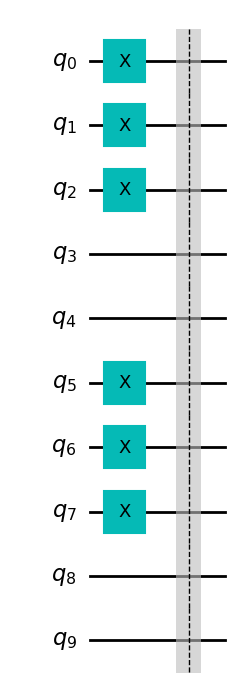

In [2]:
# compose quantum circuit 

def compose_initial_circuit(circuit, _M, _Nu, _Nd):
    for i in range(_Nu):
        circuit.x(i) 
    for i in range(_Nd): 
        circuit.x(_M+i)
    return circuit

circ_initial = compose_initial_circuit(deepcopy(circ_empty), M, Nu, Nd)
circ_initial.barrier()
circ_initial.draw(output = 'mpl')

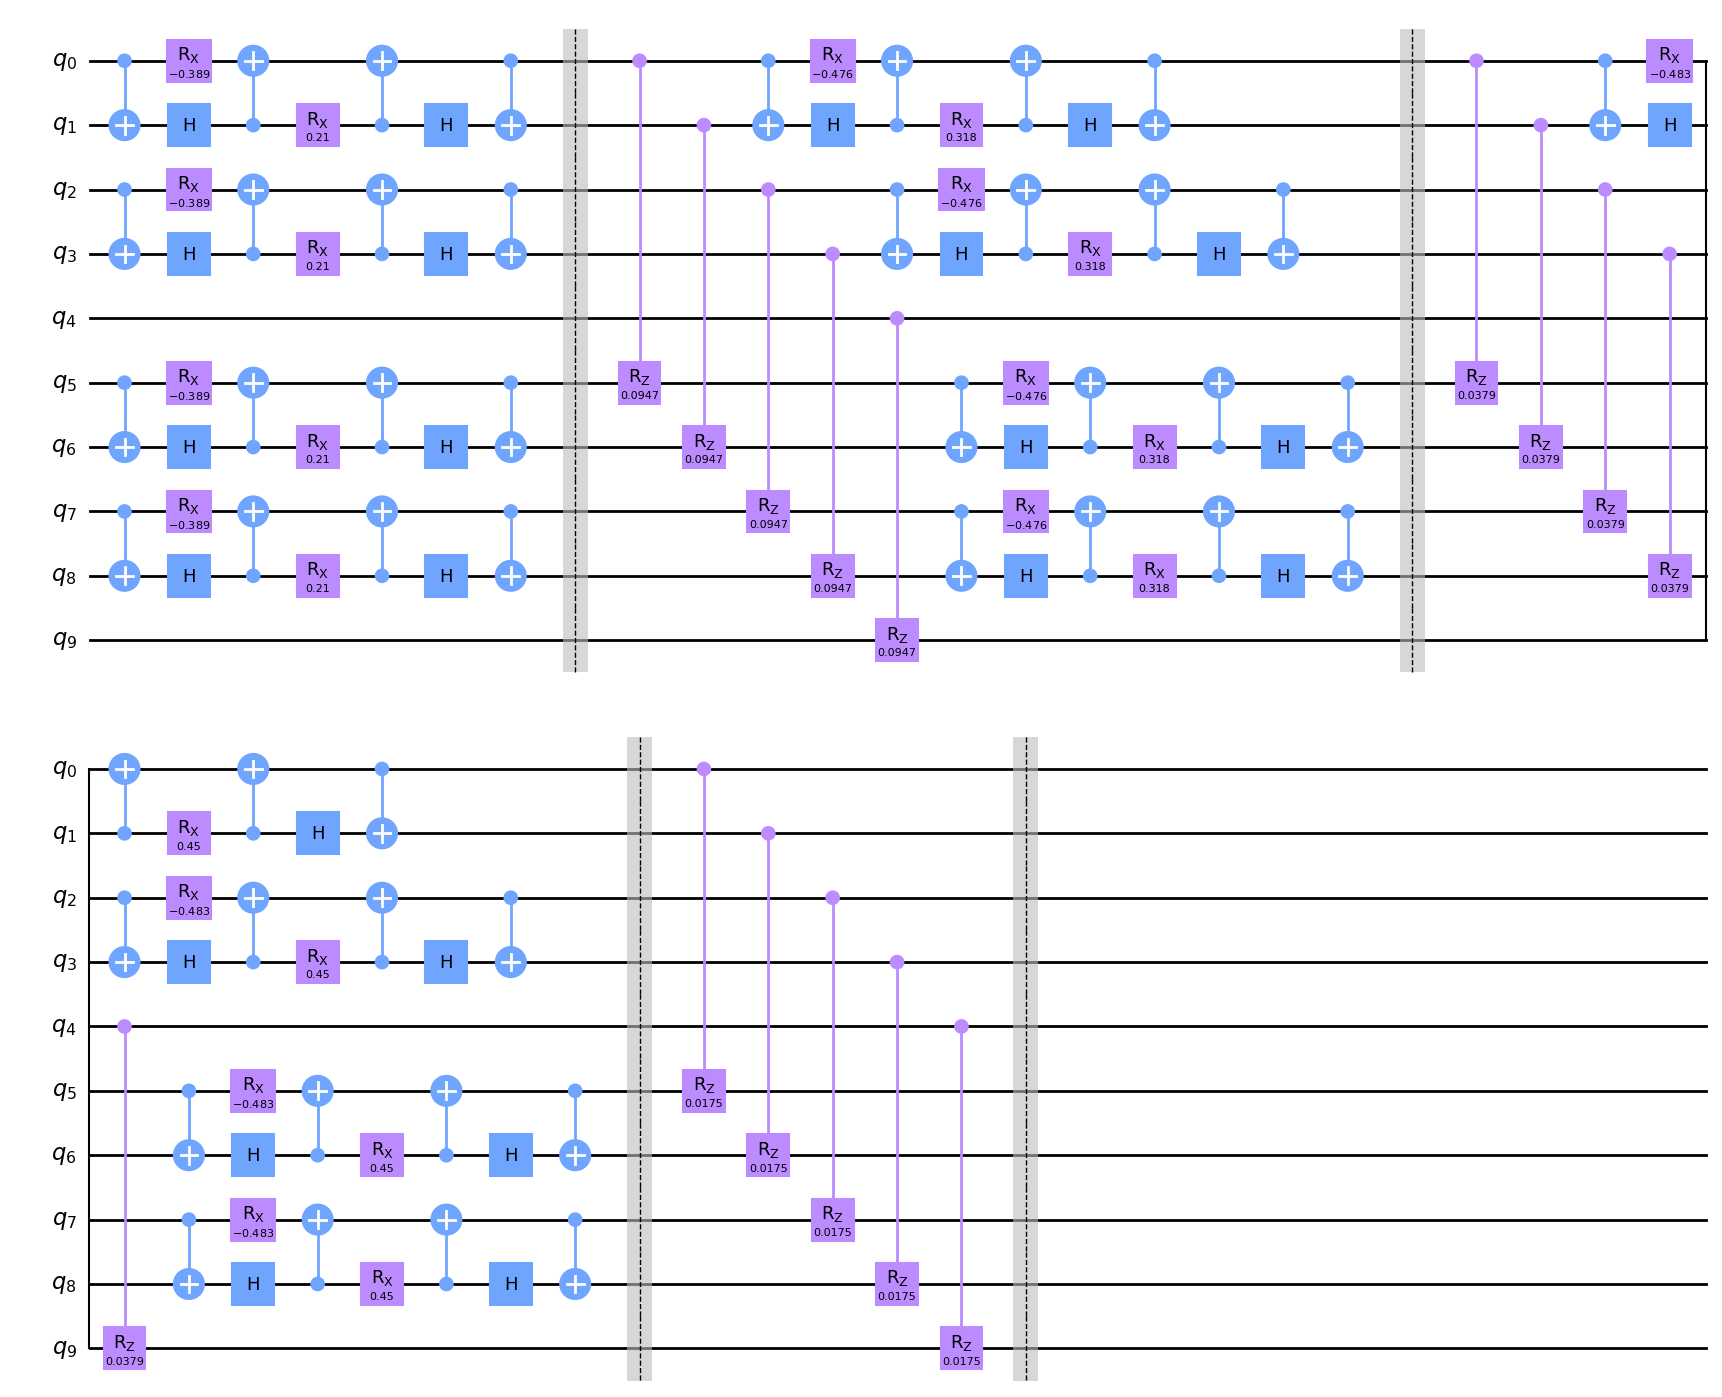

In [3]:
# compose quantum circuit 

def compose_ansatz_circuit(circuit, _M, _S, _theta): 
    # scale theta based on t and U
    _theta[:, :4] = -t/2.0*_theta[:, :4]
    _theta[:, 4] = U*_theta[:, 4]
    # loop over S Trotter-Suzuki steps 
    for j in range(_S):
        # XX and YY interactions: loop over even and odd terms
        for parity in [0]:
            # loop over orbitals
            for i in range(_M-1):
                if i%2 == parity:
                    # loop over spin up and down qubits
                    for spin_index in [0, _M]: 
                        circuit.cx(spin_index+i, spin_index+i+1)
                        circuit.rx(_theta[j, 2*parity+0], spin_index+i)    # theta_j,xe(o)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.rx(-_theta[j, 2*parity+1], spin_index+i+1) # theta_j,ye(o)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i, spin_index+i+1) 
        # barrier
        circuit.barrier()
        # ZZ interactions
        # loop over orbitals
        for i in range(_M):
            circuit.crz(_theta[j, 4], i, _M+i)
    return circuit

circ_ansatz = compose_ansatz_circuit(deepcopy(circ_empty), M, S, theta)
circ_ansatz.barrier()
circ_ansatz.draw(output = 'mpl')

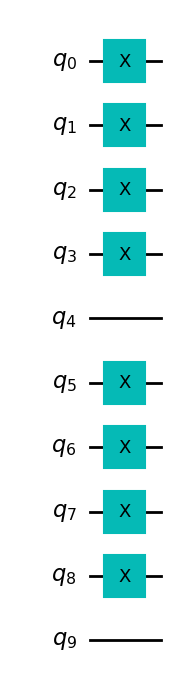

In [4]:
# compose quantum circuit 

def compose_measurement_circuit(circuit, _M, which_term):
    if which_term == "xe": 
        for i in range(_M-1):
            circuit.x(i)
            circuit.x(_M+i)
    elif which_term == "xo": 
        for i in range(_M-1):
            circuit.x(i+1)
            circuit.x(_M+i+1)
    elif which_term == "ye": 
        for i in range(_M-1):
            circuit.y(i)
            circuit.y(_M+i)
    elif which_term == "yo": 
        for i in range(_M-1):
            circuit.y(i+1)
            circuit.y(_M+i+1)
    else:
        pass
    return circuit 

circ_measurement = compose_measurement_circuit(deepcopy(circ_empty), M, "xe")
circ_measurement.draw(output='mpl')

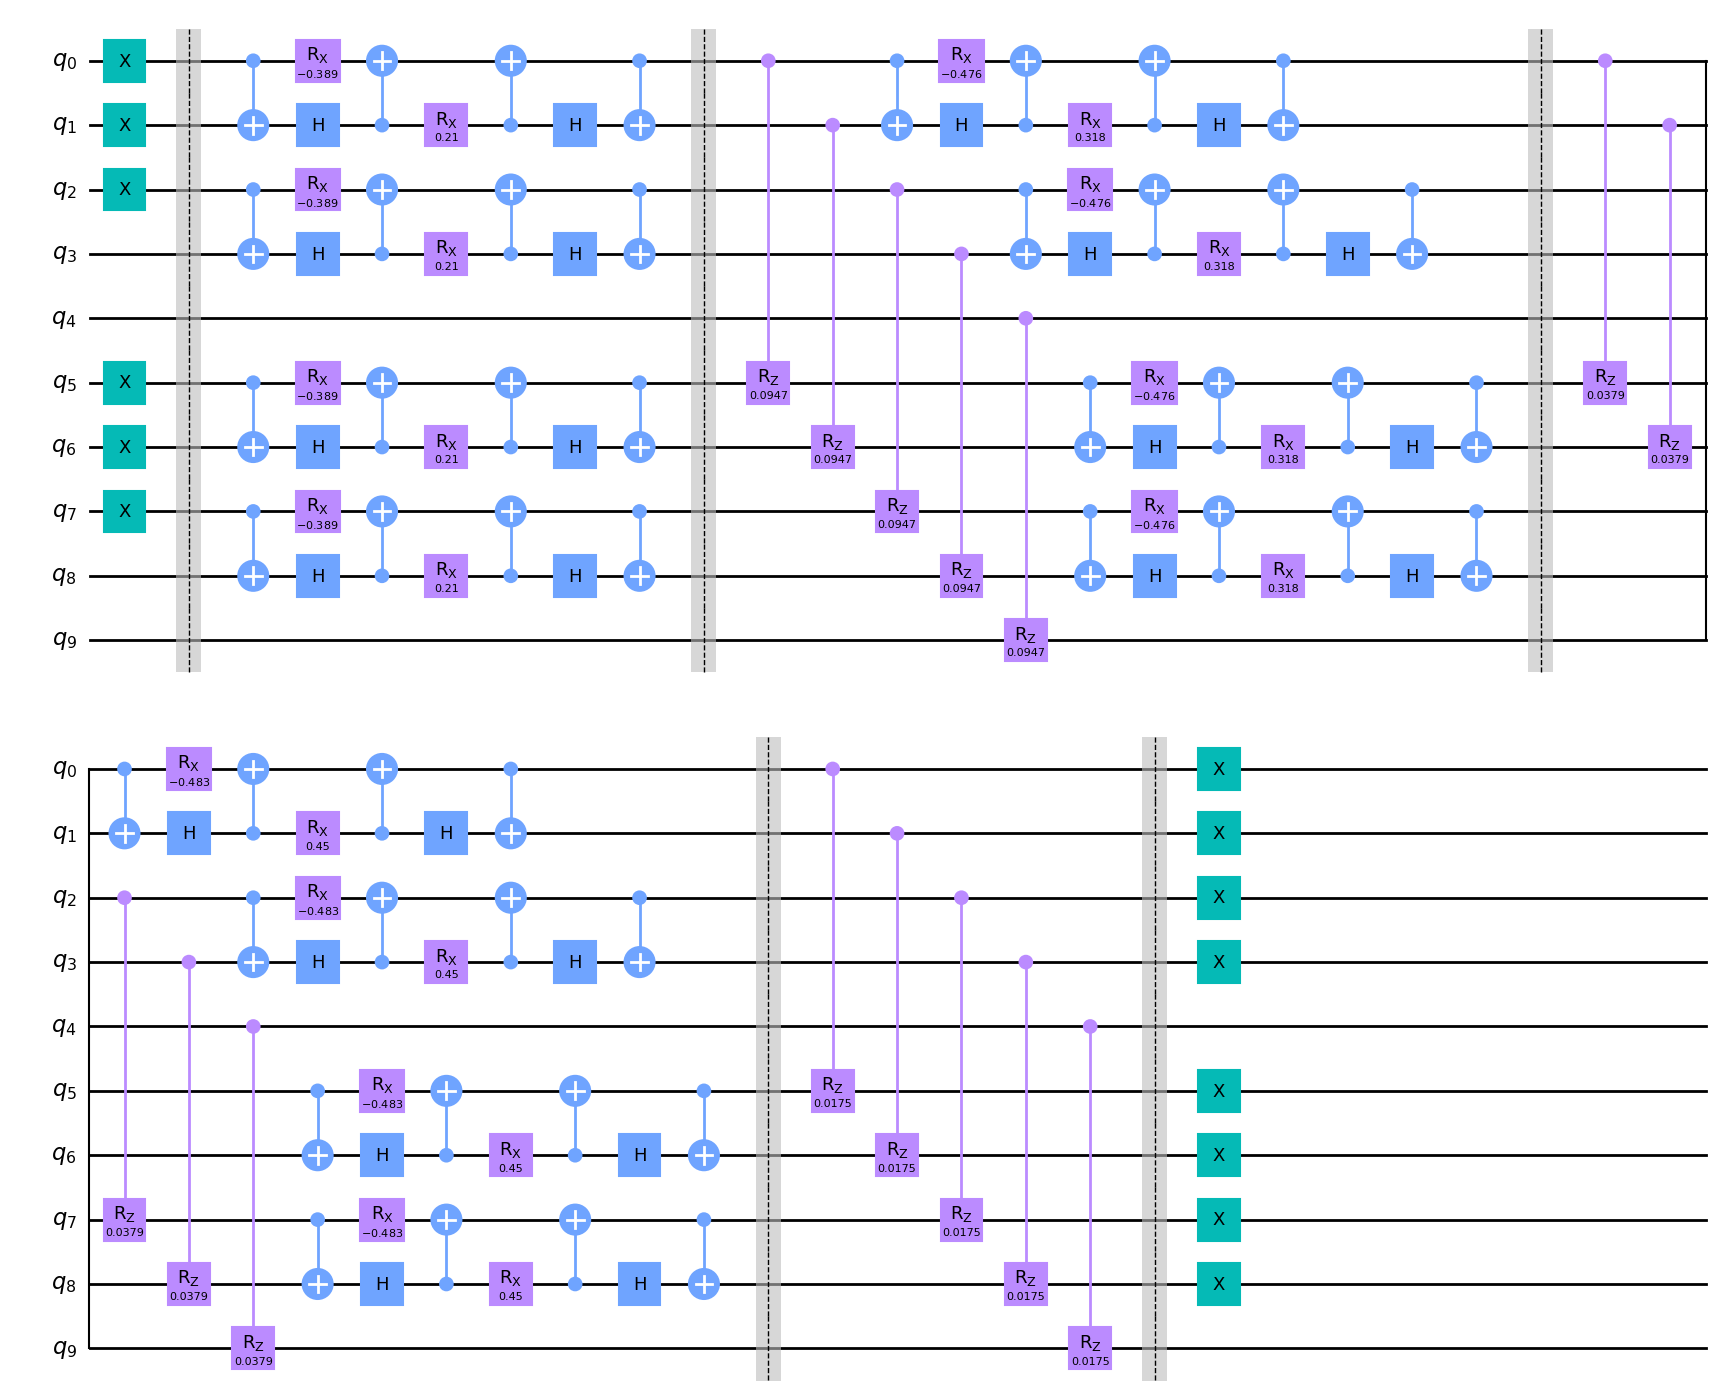

In [5]:
x = circ_initial
y = circ_ansatz
z = circ_measurement
m = x.compose(y)
n = m.compose(z)
# circ_complete = circ_complete.compose(circ_measurement)
n.draw(output = 'mpl')